In [19]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Normalize, Lambda

device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from data import CatDataset
from diffusion import Diffusion, get_named_beta_schedule
from trainer import Trainer
from unet import UNet

/home/xallt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = CatDataset(
    'data/cats_256_aligned',
    transform = Compose([
        Lambda(lambda x: x.float()),
        Normalize(127.5, 127.5),
    ])
)

sample.shape torch.Size([3, 256, 256])
sample.min() tensor(-1.)
sample.max() tensor(1.)


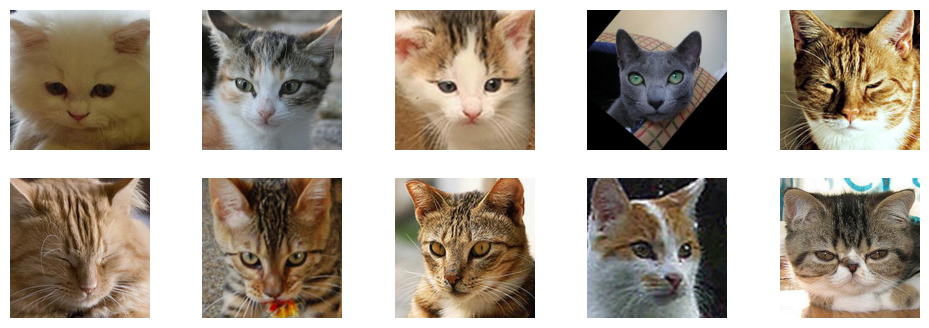

In [4]:
# Inspect dataset
indices = np.random.choice(len(ds), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in zip(indices, axes.flatten()):
    ax.imshow(ds[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')

sample = ds[0]
print("sample.shape", sample.shape)
print("sample.min()", sample.min())
print("sample.max()", sample.max())


In [8]:
model = UNet(
    in_channels=3,
    out_channels=3,
    levels=2,
    time_emb_dim=128,
    initial_features=32,
).cuda()
diffusion = Diffusion(
    betas=get_named_beta_schedule('sigmoid', 1000),
    mode="pred_start"
)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("model parameters", count_parameters(model))

model parameters 614915


In [16]:
trainer = Trainer(
    diffusion,
    model,
    # ds.train_loader(batch_size=2),
    torch.utils.data.DataLoader(ds, batch_size=1, sampler=[0]),
    lr=1e-3,
    weight_decay=1e-4,
    num_epochs=100000,
    log_every=1,
    device='cuda',
    checkpoint_file='checkpoints/model.pt'
)

In [17]:
trainer.run_loop(False)

RuntimeError: Parent directory checkpoints does not exist.

# Debug

In [21]:
model.eval()
x0 = ds[0][None].to(device)
noise = torch.randn_like(x0)
t = torch.tensor([50]).to(device).long()
x_t = diffusion.q_sample(x0, t, noise)
with torch.no_grad():
    x0_hat = model(x_t, t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


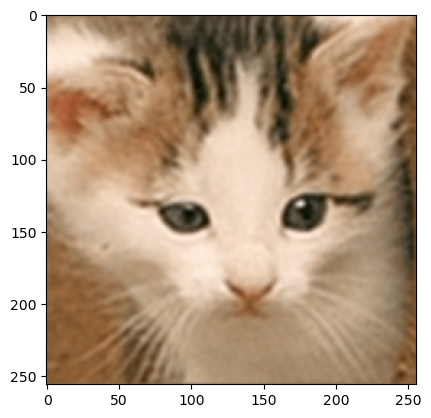

In [23]:
plt.imshow(x0_hat[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)